<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/Copy_of_MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0rc2
#!pip install -q pyyaml h5py
#!pip install -q tf_nightly
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals

  Using cached https://files.pythonhosted.org/packages/46/b2/0a8f6f62cdd91c7d727efc717f339265ace99b36847f2bda7a9f2897cfee/tensorflow-2.0.0rc2-cp36-cp36m-manylinux2010_x86_64.whl


## System funktionsweise Allgemeine Daten

#### Rauschen
genarats-> **shape**: batch_size * number_of_real_channels_uses_per_message \\
and does a average power normalization


#### Generator
Eingang: (2*n,32)  ; Ausgang: (32,n)   \\
Loss-Function:

#### Discriminator
Eingang: (2*n,32)  ; Ausgang: (32,1)  \\
Loss-Function:


#### Training


###Systemparameter
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses **What is meant by that??** \\
$N$ - Länge des Rauschvektors

In [0]:
k = 2       # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 4       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results
D_nb_weights = 32
G_nb_weights = 32


batch_size = 1000




x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
def make_zero(x):
  return tf.keras.backend.zeros(shape=x.shape)

## Generator Model

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

#numpy version of kl divergence
def kl_divergence_np(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w=1e-5
    p = p + w
    q = q + w
    return np.sum(p * np.log(p / q))

#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.log(p / q))
  
  
  
train_SNR_dB = 7
noise_std = EbNo2Sigma(train_SNR_dB)

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
#zero_initial = tf.keras.initializers.Zeros()

In [5]:
#

#def generator(x):
    # Concatenate z and y
#    G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32)  #create noise directly within the generator  
#    inputs = tf.concat(values=[x, G_n], axis=1)
    #dense NN
#    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
#    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
#    G_lin = tf.matmul(G_h2, G_W3) + G_b3
    #G_prob = tf.nn.sigmoid(G_lin)
#    return G_lin

def generator_noise(x):
  G_n = tf.random.normal([tf.shape(x)[0],n])  #create noise directly within the generator  
  return G_n
    
tf.print(generator_noise(x).shape)

#def get_generator(input = tf.keras.Input(shape=(batch_size,n)),training = False):
#  model = tf.keras.Sequential()
#  model.add(tf.keras.layers.Lambda(generator_noise))
#  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu'))#,input_shape=((2*n,))))
#  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu'))
#  model.add(tf.keras.layers.Dense(n,use_bias=False, activation='sigmoid'))
#  return model


#input1 = tf.keras.layers.Input(shape=(n,))
#x1 = tf.keras.layers.Dense(n, activation='relu')(input1)
#input2 = tf.keras.layers.Input(shape=(n,)) #tf.keras.backend.zeros(shape=(n,))# Input(shape=(n,))
#input3 = tf.keras.layers.GaussianNoise(noise_std)(input2) #input1,stddev =0.5
#x2 = tf.keras.layers.Dense(n, activation='relu')(input3)
#Equivalent to subtracted = keras.layers.subtract([x1, x2])
#subtracted = tf.keras.layers.Concatenate(-1)([x1, x2])
#h1 = tf.keras.layers.Dense(32)(subtracted)
#h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
#out = tf.keras.layers.Dense(n, use_bias= False, activation='relu')(h2)

#tf.reshape(input,(tf.shape(input)[0],-1))
input1 = tf.keras.layers.Input(shape=(n,))
x1 = tf.keras.layers.Dense(n)(input1)
input2 =tf.random.normal([tf.shape(input1)[0],n]) 
x2 = tf.keras.layers.Dense(n)(input2)
subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
h1 = tf.keras.layers.Dense(32,use_bias=True,  activation='relu')(subtracted)
h2 = tf.keras.layers.Dense(32,use_bias=True, activation='relu')(h1)
out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)

#input2 = tf.keras.layers.Input(shape=(n,)) #tf.keras.backend.zeros(shape=(n,))# Input(shape=(n,))
#input3 = tf.keras.layers.GaussianNoise(noise_std)(input2) #input1,stddev =0.5
#x2 = tf.keras.layers.Dense(n, activation='relu')(input3)
#Equivalent to subtracted = keras.layers.subtract([x1, x2])




#generator = tf.keras.models.Model(inputs=[input1, input2], outputs=out)
generator = tf.keras.models.Model(inputs=[input1], outputs=out)
generator.summary()
#print(x.shape,(generator_noise(x)).shape)
tf.print(generator([x]).shape)
#test = generator(x)
#print(test[1])
generator.input
#model.input

TensorShape([1000, 4])
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_random_normal/shape [(2,)]               0           tf_op_layer_strided_slice[0][0]  
_______________________________________________________________________

<tf.Tensor 'input_1:0' shape=(None, 4) dtype=float32>

### Help Functions

## Channels as Black-Box

In [0]:


def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


## Discriminator
Model definition and creating discriminator


In [7]:
def concc(y,x):  
  inputs = tf.concat(values=[y,x], axis=1)
  return inputs

def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  #model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model
discriminator = get_discriminator()

discriminator.summary()

#def discriminator(y,x):
#    # Concatenate x and y
#    inputs = tf.concat(values=[y,x], axis=1)
#    #dense NN
#    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
#    D_logit = tf.matmul(D_h1, D_W2) + D_b2
#    D_prob = tf.nn.sigmoid(D_logit)
#    return D_prob, D_logit

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 32        
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Define Loss
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

## defining Loss. TODO:
compile the Model with the right loss functions

In [9]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=-1)  
fake_training_data = tf.concat(values=[generator([x]),x], axis=-1)# training =True),x], axis=-1)

tf.print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
tf.print(fake_output)
tf.print(real_output)
#print(real_output, fake_output)

TensorShape([1000, 8]) TensorShape([1000, 8])
[[0.495548904]
 [0.494939983]
 [0.487576902]
 ...
 [0.49256435]
 [0.506556869]
 [0.50652045]]
[[0.516591847]
 [0.530786157]
 [0.490795642]
 ...
 [0.503625929]
 [0.458086193]
 [0.503744185]]


In [0]:
#def discriminator_loss(real_output, fake_output):
  #loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#  loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)  #Wasserstein GAN
#  return loss

def generator_loss(fake_output, generator):
  return -tf.reduce_mean(fake_output)


# Learning Rate

In [11]:
disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)   #use "-" sign to minimize rather than maximize loss
gen_loss =  -tf.reduce_mean(fake_output)
#disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output)) #-tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
#gen_loss =-tf.reduce_mean(tf.math.log(fake_output))

tf.print(disc_loss, gen_loss)

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #RMSprop   in oreder to test where the error comes from
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)      #

0.00106364489 -0.494426847


# Evaluation with Histogram

In [0]:
def generate_evaluation_data(batch_size=1000):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator([x]), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 3
  
  #inputs_ = tf.concat(values=[inputs, inputs],  axis=0)
  
  fake_output_hist = np.mean(fake_eval_data,axis=0)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=0)
  inputs_hist = np.mean(inputs,axis=0)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  tf.print(inputs_hist.shape)
  
  #fake_noise = np.reshape( fake_output_hist - inputs_hist,[-1,])
  #real_noise = np.reshape( real_output_hist - inputs_hist,[-1,])
   
  #plt.hist(fake_noise,bins=300,range=(-hist_range,hist_range),density=True,histtype='step')
  #plt.hist(real_noise,bins=300,range=(-hist_range,hist_range),density=True,histtype='step')    
  #plt.title("noise distribution after subtracting Inpus_noise")
  #plt.legend(["generator", "target"])
  #plt.show()
    
    #print("decision for fake data was %d: and for real data was %d:" % (decision_fake, decision_real))

### Define the training loop

In [0]:
epochs = 2000
steps_per_epoches = 100
batch_size = 1000

evaluation_per_epochs = 10

seed = tf.random.normal([batch_size, n])



# Wasserstein clipping

In [0]:
#clip_D = [p.assign(tf.clip_by_value(p, -0.001, 0.001)) for p in discriminator.trainable_variables]

#def get_disc_grad(trainable_variables):
#  return [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in trainable_variables]


In [0]:
def train(epochs, steps_per_epoches , batch_size):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    #print(massege_batch)
    counter += 1

    
    train_step() 
    #tf.print(generator_optimizer.apply_gradients())
    #if counter%5 == 0:
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator([x,generator_noise(x)])
      tf.print(fake_c[0])
    if counter%6 == 0 and counter<8:
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
    if counter%1000 == 0:
      real_c = real_channel(x)
      fake_c = generator([x,generator_noise(x)])
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
      tf.print(fake_c[0])
      tf.print(disc_loss, gen_loss)
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #print(x)
    fake_c = generator([x,generator_noise(x)])
    if tf.math.is_nan(fake_c[0,0]) == True:
      print("doesn't train the generator as expacted")
      tf.debugging.check_numerics(fake_c,'message generator',name=None)
      break # in order to finde wher the [nan] - prolem is cumming from
    
       
  #checkpoint_path = "training_1/cp.ckpt"
  #checkpoint_dir = os.path.dirname(checkpoint_path)

  #cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
  #                                               save_weights_only=False,
  #                                               verbose=1)    
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
 # print(gradients_of_generator)  
  

  # Generate after the final epoch
    


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
#@tf.function
#def train_step(massege_batch,counter):
#    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
#    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
    #inputs = tf.concat(values=[x, G_n], axis=1)
#    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  #tf.concat(values=[real_channel(x),x], axis=1)


 #   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:           #tapes the gradient of the generaor an the discriminator
  #    fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      
 #     real_output = discriminator(real_training_data, training=True)
 #     fake_output = discriminator(fake_training_data, training=True)

 #     disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
 #     gen_loss = -tf.reduce_mean(tf.math.log(fake_output))

 #     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
 #     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  #    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    


In [0]:
@tf.function
def train_step(): #epoch, steps_per_epoches , batch_size, generator, discriminator):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  for i in range(5):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(x), x], axis=1)
      fake_training_data = tf.concat(values=[generator(x),x], axis=1)# training =True),x], axis=1)
      real_output = discriminator(real_training_data)#, training=True)
      fake_output = discriminator(fake_training_data)
      
      
      #disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)  #use "-" sign to minimize rather than maximize loss
      #gen_loss =  -tf.reduce_mean(fake_output)
      #tf.print(real_training_data.shape, real_output[1].shape)
      #tf.debugging.check_numerics(disc_loss,'loss generator',name=None)
      # clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in gradients_of_discriminator]   
      #tf.print(real_training_data[0])
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output)) #-tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      #disc_loss = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)   #use "-" sign to minimize rather than maximize loss
      #gen_loss =  -tf.reduce_mean(fake_output)
      #tf.print(disc_loss, gen_loss)
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        #tf.print(disc_loss, gen_loss)
      if i == 4:  
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        #tf.print(disc_loss, gen_loss)



## Train the model

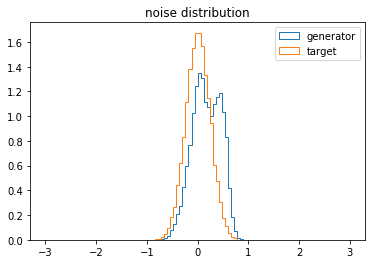

(1000, 4)
counter 100:
[0.695254803 -0.117476314 0.00339130405 0.480147451]
counter 200:
[0.0953111947 -0.330191284 -0.221802354 -0.131656989]
counter 300:
[-0.406550676 -0.135615245 0.218698591 -0.06739299]
counter 400:
[-0.260532081 0.153131306 -0.0523516685 0.0530016907]
counter 500:
[0.301829785 -0.795693159 0.625965595 0.550819099]
counter 600:
[0.258168429 -0.712454 0.00277994247 -0.423574984]
counter 700:
[-0.337060064 0.301970899 -0.205628067 -0.720262289]
counter 800:
[-0.0121632265 0.25493139 0.142879486 -0.331622124]
counter 900:
[0.203526184 0.416532218 -1.46986771 1.17589903]
counter 1000:
[-1.05808103 0.920227528 -0.204109505 -0.61342448]


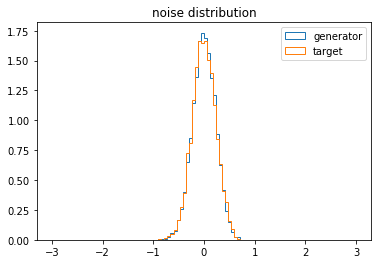

(1000, 4)
[0.0156454928 0.349244475 -0.155790314 -0.856909275]
0.00106364489 -0.494426847
Time for epoch 1000,
counter 1100:
[0.480582833 1.04332483 0.56907028 0.0474329665]
counter 1200:
[-0.173024267 0.688510299 0.466544718 -0.89406538]
counter 1300:
[-0.211620033 -0.0798177719 0.403482586 -0.936527]
counter 1400:
[-0.164042458 -0.840667605 0.00366452336 -0.0390043408]
counter 1500:
[-1.61765027 -0.109590448 0.379620582 -0.736064076]
counter 1600:
[0.632680774 0.313120812 -0.99520421 -0.649045825]
counter 1700:
[-0.384256542 -0.268873692 0.530815065 0.255724221]
counter 1800:
[-0.107434049 -1.03198493 -0.186376095 -0.451193422]
counter 1900:
[-0.325075775 0.921895921 -1.53130126 -1.05554879]
counter 2000:
[0.282649904 -0.946329474 0.986231387 -0.096155934]


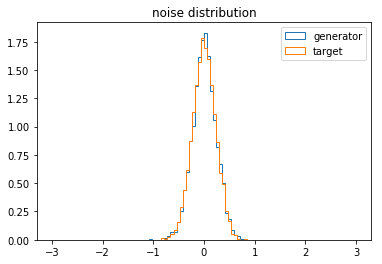

(1000, 4)
[-0.109815642 -0.888151705 0.893469334 -0.12715444]
0.00106364489 -0.494426847
Time for epoch 2000,
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/saved_model/assets
Time for the training is 103.43600177764893 sec,
tf.Tensor([-0.1266843  0.4362536  1.1032234 -0.8043564], shape=(4,), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_la

In [16]:
%%time
train(epochs, steps_per_epoches , batch_size)
print(generator(x)[1])
generator.summary()
discriminator.summary()

In [17]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
#print(x)
real_c = real_channel(x)
fake_c = generator([x])
tf.print(real_c.shape)
tf.print(fake_c.shape)

#tf.debugging.check_numerics(fake_c,'message',name=None)

TensorShape([1000, 4])
TensorShape([1000, 4])


## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




In [31]:
def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber


#def get_encoder():
#  model = tf.keras.Sequential()
#  model.add(tf.keras.layers.InputLayer(input_shape=[M]))
#  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='elu'))
  #model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
#  model.add(tf.keras.layers.Dense(n,use_bias=False, activation=None))
#  model.add(tf.keras.layers.Lambda(lambda x : tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x))))))
#  return model

#def get_decoder():
#  model = tf.keras.Sequential()
#  model.add(tf.keras.layers.InputLayer(input_shape=[n]))
#  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='elu'))
  #model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
#  model.add(tf.keras.layers.Dense(M,use_bias=False, activation='softmax'))
#  return model

#encoder = get_encoder()
#decoder = get_decoder()


   

#def test_Model(x):
#  y = encoder(x)
#  y = generator([y,make_zero(y)])
#  y = decoder(y)
#  return y
  
#****************************************************  From  Rick Fritschek "Communication-via-Autoencoder-TF2"

  


gen_shape_layer = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
#gen_shape_layer = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
gen_shape_layer2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))




def decoder(input):
  '''The Receiver'''
  y = tf.reshape(input, shape=[-1,n])
  y = tf.keras.layers.Dense(M, activation='relu')(y)
  y = tf.keras.layers.Dense(M, activation=None)(y)
  return y



def encoder(input):
  '''The transmitter'''
  low = np.sqrt(6.0/(2*M)) 
  high = -np.sqrt(6.0/(2*M))
  W =tf.random.uniform((M,M), minval=low, maxval=high, dtype=tf.float32)    
  x = tf.nn.elu(tf.nn.embedding_lookup(W, input))
  x = tf.keras.layers.Dense(n, activation=None)(x)
  x = tf.reshape(x, shape=[-1,int(n/2),2])
  #Average power normalization
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) 
  return x

bl = generate_data_vector(1000)
bla =encoder(bl)            #ecoder: (4, 2, 2)
blaa =tf.reshape(x,(tf.shape(x)[0],-1))
blaaa = generator(blaa)
blaaaa = tf.reshape(blaaa, shape=[-1,int(n/2),2])
blaaaaa = decoder(blaaa)

print('encoder input',bl.dtype)
print('encoder output',bla.dtype)
print('reshaped generator input',blaa.shape)
print('generator output',blaaa.shape)
print('reshaped generator output',blaaaa.shape)
print('decoder output',blaaaaa.shape)


EncIn = tf.keras.layers.Input(shape=(n,), dtype= tf.int32)
EncOut = tf.keras.layers.Lambda(encoder)(EncIn)
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))(EncOut)
GenOut = tf.keras.layers.Lambda(generator)(GenIn)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))(GenOut)
out = tf.keras.layers.Lambda(decoder)(DecIn)



AE = tf.keras.models.Model(inputs=EncIn, outputs=out)
AE.summary()




#encoder = keras.models.Sequential([
#tf.keras.layers.InputLayer(input_shape=[M]),
#tf.keras.layers.Dense(M, activation="relu"),
#tf.keras.layers.Dense(2*n, activation=None),
#shape_layer,
#norm_layer])



#channel = keras.models.Sequential([channel_layer])

#decoder = keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=[2,n]),
#shape_layer2,
#tf.keras.layers.Dense(M, activation="relu"),
#tf.keras.layers.Dense(M, activation="softmax")
#])  
  
#encoder.summary()
#generator.summary()
#decoder.summary() 



#def get_AE():
#  AE_model = tf.keras.Sequential()
#  AE_model.add(tf.keras.layers.Lambda(encoder))
#  AE_model.add(gen_shape_layer)
#  AE_model.add(tf.keras.layers.Lambda(generator))
#  AE_model.add(gen_shape_layer2)
#  AE_model.add(tf.keras.layers.Lambda(decoder))
 # return AE_model
  
  
  
  
  
  
  


def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  tf.print(random_hot_one_vector.shape)
  return random_hot_one_vector

data, test_data = generate_data_vector(10000000), generate_data_vector(10000)
#print(data)

#model = Autoencoder()
#AE = get_AE()
AE.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[B_Ber])
history = AE.fit(data, data, batch_size=1000,steps_per_epoch=1000, epochs=6)



  

TensorShape([1000, 4])
encoder input <dtype: 'int32'>
encoder output <dtype: 'float32'>
reshaped generator input (1000, 4)
generator output (1000, 4)
reshaped generator output (1000, 2, 2)
decoder output (1000, 4)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
lambda_51 (Lambda)           (None, 2, 2)              20        
_________________________________________________________________
lambda_52 (Lambda)           (None, None)              0         
_________________________________________________________________
lambda_53 (Lambda)           (None, 4)                 1516      
_________________________________________________________________
lambda_54 (Lambda)           (None, 2, 2)              0         
___________________________________________

ValueError: ignored

In [0]:


def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = generator(y)
  y = decoder(y)
  return y
  #model = tf.keras.Sequential()
  #model.add(encoder)
  #model.add(tf.keras.layers.Lambda(generator))
  #model.add(tf.keras.layers.Lambda(real_channel))
  #model.add(decoder)
  #return model

def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i,:], results[i,:]))
  return diff
    
  
real_AE = real_transmision(test_data)
testTest = tf.dtypes.cast(real_AE + tf.constant(0.1,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

diff_test =  test_diff_eval(test_data, testTest) 
#t = tf.math.subtract(test_data[1,:], real_AE[1,:])





In [0]:
tf.print(sum(diff_test))

In [0]:
tes_data = np.eye(M, dtype = int)
coding= encoder.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

In [0]:
tes_data = np.eye(M, dtype = int)
coding= AE.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

## Create and train model